# Predicting stock with ANN and RNN

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import tree

input_file = "HistoricalQuotes.csv"
quote_data = pd.read_csv(input_file)
quote_data = quote_data.sort_values(by = ['date'])
quote_data.head(10)

,date,close,volume,open,high,low
1226,2014/03/27,558.46,13052.0,568.00,568.00,552.92
1225,2014/03/28,559.99,41003.0,561.20,566.43,558.67
1224,2014/03/31,556.97,10772.0,566.89,567.00,556.93
1223,2014/04/01,567.16,7932.0,558.71,568.45,558.71
1222,2014/04/02,567.00,146697.0,599.99,604.83,562.19
1221,2014/04/03,569.74,5080231.0,569.85,587.28,564.13
1220,2014/04/04,543.14,6350969.0,574.65,577.77,543.00
1219,2014/04/07,538.15,4364932.0,540.74,548.48,527.15
1218,2014/04/08,554.90,3141406.0,542.60,555.00,541.61
1217,2014/04/09,564.14,3321485.0,559.62,565.37,552.95


In [2]:
quote_data.describe()

,close,volume,open,high,low
count,1227.000000,1.227000e+03,1227.000000,1227.000000,1227.000000
mean,804.150863,1.781878e+06,804.197464,811.045403,796.854098
std,216.653417,8.945503e+05,216.444512,218.836468,214.318771
min,492.550000,7.932000e+03,494.650000,495.976000,487.560000
25%,582.885000,1.253720e+06,583.900000,586.775000,580.195000
50%,768.880000,1.559791e+06,769.250000,774.000000,764.230000
75%,1016.585000,2.041602e+06,1015.260000,1028.603700,998.830000
max,1268.330000,1.115350e+07,1271.000000,1273.890000,1249.020000


In [3]:
all_features = quote_data[['open', 'high', 'low', 'volume']].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
all_features_scaled = scaler.fit_transform(all_features)

scaler_features = MinMaxScaler()
labels = scaler.fit_transform(quote_data['close'].values.reshape(-1,1))

In [4]:
#let's start with a std NN
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# Split the data into train/test data sets with 25% reserved for testing
X_train, X_test, y_train, y_test = train_test_split(all_features_scaled, labels, test_size=0.20, random_state=0, shuffle = False)

model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(4,)))
model.add(Dense(1, activation='linear'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                250       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])


history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=100,
                    verbose=0,
                    validation_data=(X_test, y_test))

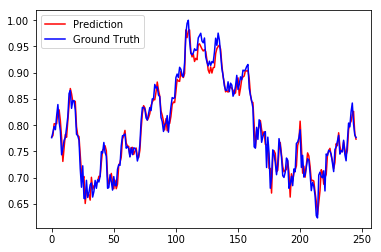

981/981 [==============================] - 0s 59us/step
Train Score: 0.00 MSE (0.01 RMSE)
246/246 [==============================] - 0s 69us/step
Test Score: 0.00 MSE (0.02 RMSE)


In [8]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))
    
# if using within a jupyter notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt

plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

#MSE Score
trainScore = model.evaluate(X_train, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=1)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

In [12]:
#let's go for an RNN
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Activation

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


window = 5
features_reshaped_train = []
features_reshaped_test = []
labels_reshaped_train = []
labels_reshaped_test = []

#resizing X_scaled_train sliding window from the beginning to the end
for i in range(0, len(X_train) - window +1):
    #appending sub list of window size
    features_reshaped_train.append(X_train[i:i + window])

#resizing X_scaled_test sliding window from the beginning to the end
for i in range(0, len(X_test) - window +1):
    #appending sub list of window size
    features_reshaped_test.append(X_test[i:i + window])

#resizing Y_scaled_train sliding window from the beginning to the end
for i in range(0, len(y_train) - window + 1):
    #appending sub list of window size
    labels_reshaped_train.append(y_train[i + window - 1])

#resizing Y_scaled_test sliding window from the beginning to the end
for i in range(0, len(y_test) - window +1):
    #appending sub list of window size
    labels_reshaped_test.append(y_test[i + window - 1])
    
features_reshaped_train = np.array(features_reshaped_train)
labels_reshaped_train = np.array(labels_reshaped_train)
features_reshaped_test = np.array(features_reshaped_test)
labels_reshaped_test = np.array(labels_reshaped_test)

print(features_reshaped_train.shape)
print(labels_reshaped_train.shape)
print(features_reshaped_train.shape)
print(labels_reshaped_test.shape)

model = Sequential()
model.add(LSTM(50, input_shape=(window, 4)))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

model.fit(
    features_reshaped_train,
    labels_reshaped_train,
    batch_size=64,
    epochs=100,
    verbose=0,
    validation_data = (features_reshaped_test,labels_reshaped_test))
    #validation_split = 0.2)

(981, 4)
(981, 1)
(246, 4)
(246, 1)
(977, 5, 4)
(977, 1)
(977, 5, 4)
(242, 1)


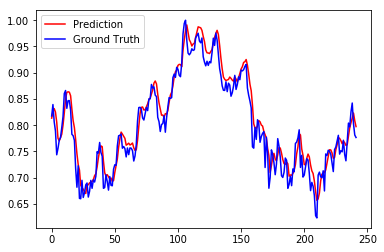

977/977 [==============================] - 0s 107us/step
Train Score: 0.00 MSE (0.01 RMSE)
242/242 [==============================] - 0s 93us/step
Test Score: 0.00 MSE (0.02 RMSE)


In [13]:
diff = []
ratio = []
pred = model.predict(features_reshaped_test)
for u in range(len(labels_reshaped_test)):
    pr = pred[u][0]
    ratio.append((labels_reshaped_test[u] / pr) - 1)
    diff.append(abs(labels_reshaped_test[u] - pr))

# if using within a jupyter notebook

%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt

plt.plot(pred, color='red', label='Prediction')
plt.plot(labels_reshaped_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

#MSE Score
trainScore = model.evaluate(features_reshaped_train, labels_reshaped_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(features_reshaped_test, labels_reshaped_test, verbose=1)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))